In [1]:
import toml
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from os.path import join
from tqdm.auto import tqdm
from rl_analysis import ANALYSIS_CONFIG
from rl_analysis.behavior.moseq import add_onset_and_duration
from rl_analysis.plotting import save_factory, setup_plotting_env, fg, clean_ticks, syllable_aliases

In [2]:
with open(ANALYSIS_CONFIG, 'r') as f:
    config = toml.load(f)

setup_plotting_env()

saver = save_factory(join(config['figures']['store_dir'], 'fig-s09'), tight_layout=False)

plt.rcParams['figure.dpi'] = 300

In [3]:
df = pd.read_parquet(
    join(config["raw_data"]["closed_loop_behavior"], "closed_loop_behavior.parquet"),
    columns=[
        "predicted_syllable",
        "target_syllable",
        "session_number",
        "uuid",
        "feedback_status",
        "area",
        "stim_duration",
        "mouse_id",
    ],
)

In [4]:
df = df[
    df["session_number"].isin([1, 2])
    & df["area"].isin(["ctrl", "snc (axon)"])
    & (df["stim_duration"] == 0.25)
].copy()

In [5]:
df = add_onset_and_duration(df)
df['offset'] = np.roll(df['onset'], -1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26535142 entries, 26027885 to 77524475
Data columns (total 11 columns):
 #   Column              Dtype   
---  ------              -----   
 0   predicted_syllable  int8    
 1   target_syllable     int8    
 2   session_number      int8    
 3   uuid                object  
 4   feedback_status     int8    
 5   area                category
 6   stim_duration       float64 
 7   mouse_id            category
 8   onset               bool    
 9   dur                 uint16  
 10  offset              bool    
dtypes: bool(2), category(2), float64(1), int8(4), object(1), uint16(1)
memory usage: 860.4+ MB


In [7]:
stim_mask = (df['feedback_status'] == 1) & (df['target_syllable'] == df['predicted_syllable'])

In [8]:
target_offsets = (df['target_syllable'] == df['predicted_syllable']) & df['offset']
target_onsets = (df['target_syllable'] == df['predicted_syllable']) & df['onset']

In [9]:
# find closest onset for each stim:
onset_idx = np.where(df['onset'] & (df['target_syllable'] == df['predicted_syllable']))[0]
durs = df['dur'].iloc[onset_idx].to_numpy()
stim_idx = np.where((df['feedback_status'] == 1) & (df['target_syllable'] == df['predicted_syllable']))[0]

In [10]:
stim_frames = 0.25 * 30

In [11]:
stim_duration_df = []
for sidx in tqdm(stim_idx):
    align = sidx - onset_idx
    candidates = np.where(align > 0)[0]
    closest = np.argmin(align[candidates])
    out = {
        'onset': onset_idx[closest],
        'dur': durs[closest],
        'offset': onset_idx[closest] + durs[closest],
        'stim_offset': onset_idx[closest] + stim_frames,
    }
    out['frames_from_syll_offset'] = out['stim_offset'] - out['offset']
    out['target_syllable'] = df['target_syllable'].iloc[out['onset']]
    stim_duration_df.append(out)

  0%|          | 0/47006 [00:00<?, ?it/s]

In [12]:
stim_duration_df = pd.DataFrame(stim_duration_df)
stim_duration_df.head()

,onset,dur,offset,stim_offset,frames_from_syll_offset,target_syllable
0,671,29,700,678.5,-21.5,20
1,1831,21,1852,1838.5,-13.5,20
2,5052,25,5077,5059.5,-17.5,20
3,6964,6,6970,6971.5,1.5,20
4,8083,18,8101,8090.5,-10.5,20


In [13]:
stim_duration_df['Stim offset aligned to syllable offset (s)'] = stim_duration_df['frames_from_syll_offset'] / 30
target_stim_duration = stim_duration_df.set_index('target_syllable').sort_index()

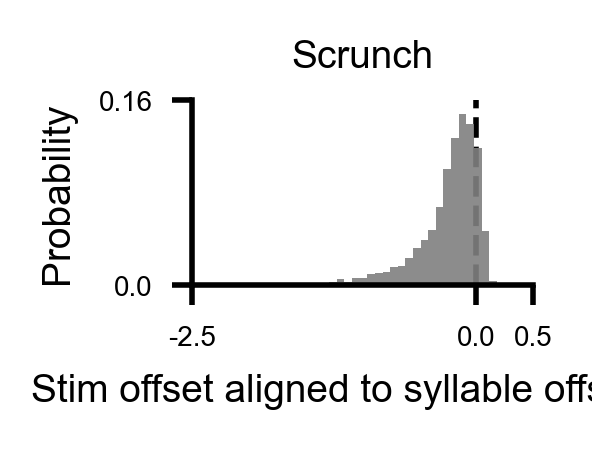

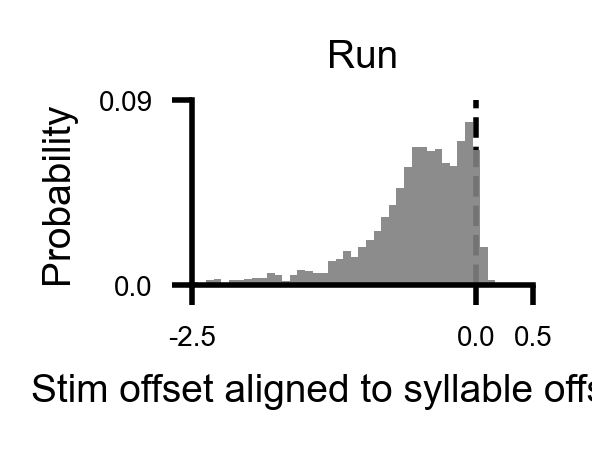

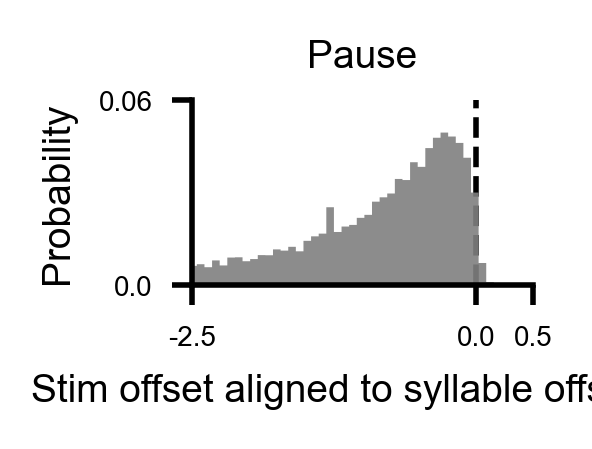

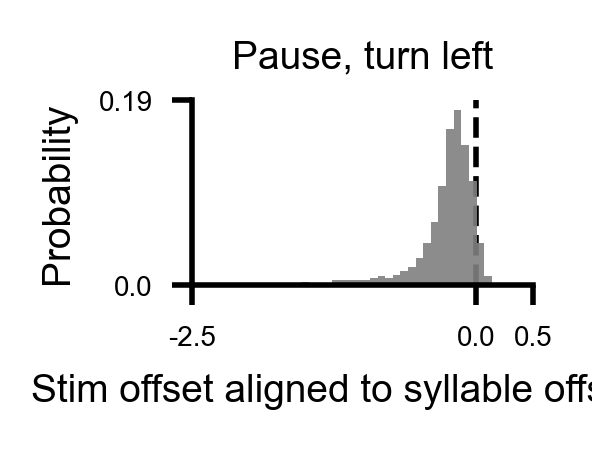

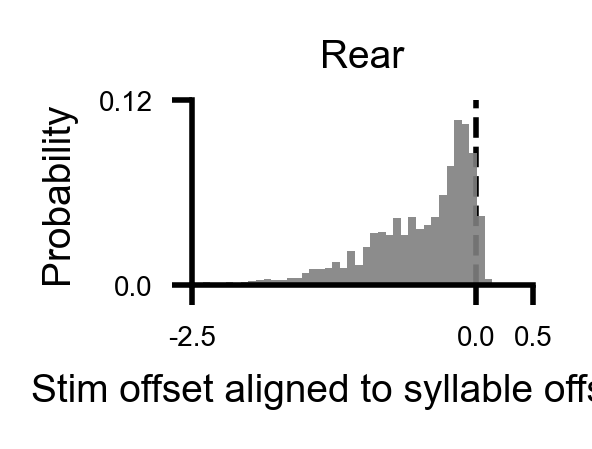

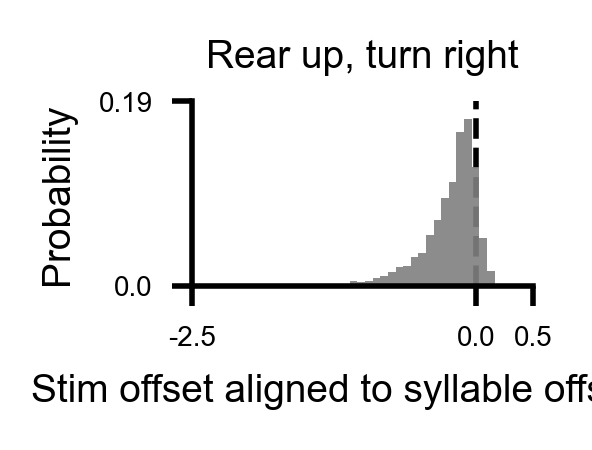

In [14]:
for target in (17, 20, 27, 30, 59, 76):
    fig = fg(1.1, 0.6)
    fig.dpi = 200
    ax = sns.histplot(
        target_stim_duration.loc[target, "Stim offset aligned to syllable offset (s)"],
        stat="probability",
        element="step",
        binwidth=0.067,
        linewidth=0,
        zorder=0,
        alpha=0.9,
        color="gray",
    )
    plt.axvline(0, linestyle="--", linewidth=1, zorder=-5, color="k")
    sns.despine()
    plt.xlim(-2.5, 0.5)
    clean_ticks(ax, zero_symmetry=False)
    clean_ticks(ax, axis="y", precision=2, zero_symmetry=False)
    ax.set_title(syllable_aliases[target])
    saver(fig, f'stim-offset-relative-to-syllable-offset-{target}')